 https://archive.ics.uci.edu/ml/datasets/Forest+Fires 



In [34]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import itertools

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

### Подготовка данных

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#Загрузка данных и описание
df = pd.read_csv('/content/drive/MyDrive/курсы/мфти/ИАДиНС/data/forestfires.csv')
print(df)
print(df.describe())

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]
                X           Y        FFMC         DMC          


Area
число записей с пожаром:270
доля записей с пожаром:52.22%


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


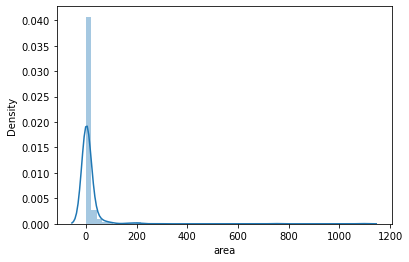

In [37]:
#Детаельное рассмотрение целевого признака
area_bool = df['area'].apply(lambda x: False if x==0 else True)
print("""
Area
число записей с пожаром:{}
доля записей с пожаром:{:.2%}""".format(area_bool.sum(),area_bool.sum()/len(area_bool)))
sns_plot = sns.distplot(df['area'])
fig = sns_plot.get_figure()

In [38]:
#Проверка на пропуски
print(df.shape)
missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(517, 13)
Series([], dtype: int64)


In [39]:
#Разделение на X,y
y = df['area']
X = df[df.columns.difference(['area'])]

In [40]:
#Кодирование категориальных данных (one-hot encoding)
object_cols = [col for col in X.columns if df[col].dtype == "object"]
print(object_cols, len(object_cols))

low_cardinality_cols = [col for col in object_cols if X[col].nunique() < 15]
print(low_cardinality_cols)

OH_cols = pd.get_dummies(X[low_cardinality_cols],prefix=low_cardinality_cols)
num_X = X.drop(low_cardinality_cols, axis=1)
OH_X = pd.concat([num_X, OH_cols], axis=1)

['day', 'month'] 2
['day', 'month']


In [41]:
#разбиваем датасет на тестовую и тренировочную выборки
train_X, test_X, train_y, test_y = train_test_split(OH_X, y, random_state=0)

In [42]:
#Отбираем признаки (Lasso-регрессия)
def select_features_l1(X, y):
        lasso = Lasso(alpha=0.1, random_state=0).fit(X, y)
        model = SelectFromModel(lasso, prefit=True)
        X_new = model.transform(X)
        selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                        index=X.index,
                                        columns=X.columns)
        cols_to_keep = selected_features.columns[selected_features.var() != 0]

        return cols_to_keep
    
selected_features = select_features_l1(train_X, train_y)
print('Отобрано признаков: {}'.format(len(selected_features)))
print(selected_features)
new_train_X = train_X[selected_features]
new_test_X = test_X[selected_features]

Отобрано признаков: 22
Index(['DC', 'DMC', 'FFMC', 'ISI', 'RH', 'X', 'Y', 'rain', 'temp', 'wind',
       'day_fri', 'day_mon', 'day_sun', 'day_thu', 'day_tue', 'day_wed',
       'month_aug', 'month_dec', 'month_jun', 'month_mar', 'month_oct',
       'month_sep'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


### Линейная регрессия

In [43]:
#Создание и обучение модели линйной регрессии
linearModel=LinearRegression()
linearModel.fit(new_train_X,train_y)
pred_linear=linearModel.predict(new_test_X)

#Отрицательную площадь пожара заменяем на 0
pred_linear = pd.Series(pred_linear)
pred_linear = pred_linear.apply(lambda x: 0 if x < 0 else x)

print('Качество модели линейной регрессии:')
print('R2_score: ',round(r2_score(test_y,pred_linear),2))
print('MSE: ',round(mean_squared_error(test_y,pred_linear),2))
print('MAE: ',round(mean_absolute_error(test_y,pred_linear),2))

Качество модели линейной регрессии:
R2_score:  0.01
MSE:  9649.39
MAE:  23.2


### Полиномиальная регрессия

In [22]:
#Получение квадратов отобранных признаков
def polinom_transform (df,num_features,degree=2):
    df_copy = df.copy()
    if degree == 1:
        return df_copy
    else:
        for i in range(2,degree+1):
            for j in num_features:
                df_copy[j+str(i)]=df_copy[j]**i
        return df_copy

In [44]:
#Задаём числовые признаки (которые можно возвести в степень)
num_fetures = ['DC','DMC','FFMC','ISI','RH','X','Y','rain','temp','wind']

In [24]:
def get_MAE_polinomial(n,num_fetures):
    train_X_p = polinom_transform(new_train_X,num_fetures,n)
    polinomialModel=LinearRegression()
    scores = cross_val_score(polinomialModel, train_X_p, train_y,cv=3,scoring='neg_mean_absolute_error')
    return scores.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/3 [00:00<?, ?it/s]

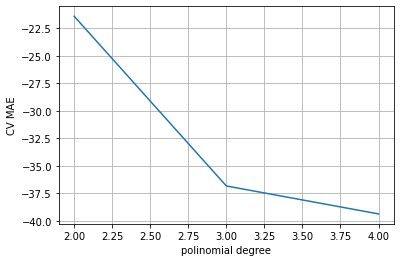

In [45]:
#Определяем оптимальное значение max_depth
result_cv = []
parameter = []
for i in tqdm_notebook(range(2,5)):
    result_cv.append(get_MAE_polinomial(i,num_fetures))
    parameter.append(i)
    
fig, ax = plt.subplots()
ax.plot(parameter, result_cv)

ax.set(xlabel='polinomial degree', ylabel='CV MAE')
ax.grid()
plt.show()

In [46]:
train_X_polinomial=polinom_transform(new_train_X,num_fetures,2)
test_X_polinomial=polinom_transform(new_test_X,num_fetures,2)

In [47]:
#Создание и обучение модели полиномиальной регрессии
polinomialModel=LinearRegression()
polinomialModel.fit(train_X_polinomial,train_y)
pred_polinomial=polinomialModel.predict(test_X_polinomial)

#Отрицательную площадь пожара заменяем на 0
pred_polinomial = pd.Series(pred_linear)
pred_polinomial = pred_polinomial.apply(lambda x: 0 if x < 0 else x)

print('Качество модели линейной регрессии:')
print('R2_score: ',round(r2_score(test_y,pred_polinomial),2))
print('MSE: ',round(mean_squared_error(test_y,pred_polinomial),2))
print('MAE: ',round(mean_absolute_error(test_y,pred_polinomial),2))

Качество модели линейной регрессии:
R2_score:  0.01
MSE:  9649.39
MAE:  23.2


### Случайный лес


In [48]:
def get_MAE_rf(n_estimators,max_depth=None):
    rf_model = RandomForestRegressor(n_estimators=n_estimators,
                                     max_depth=max_depth,
                                     random_state=0)
    scores = cross_val_score(rf_model, train_X, train_y,cv=3,scoring='neg_mean_absolute_error')
    return scores.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/9 [00:00<?, ?it/s]

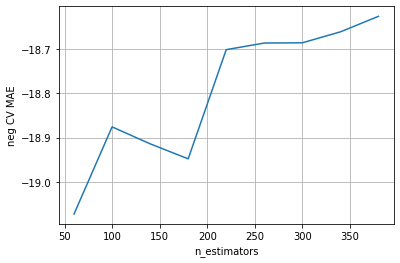

In [49]:
#Определяем оптимальное значение n_estimators
result_cv = []
parameter = []
for i in tqdm_notebook(range(3,20,2)):
    result_cv.append(get_MAE_rf(n_estimators=20*i))
    parameter.append(20*i)
    
fig, ax = plt.subplots()
ax.plot(parameter, result_cv)

ax.set(xlabel='n_estimators', ylabel='neg CV MAE')
ax.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/9 [00:00<?, ?it/s]

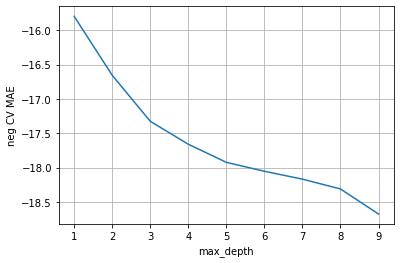

In [50]:
#Определяем оптимальное значение max_depth
result_cv = []
parameter = []
for i in tqdm_notebook(range(1,10)):
    result_cv.append(get_MAE_rf(n_estimators=220,max_depth=i))
    parameter.append(i)
    
fig, ax = plt.subplots()
ax.plot(parameter, result_cv)

ax.set(xlabel='max_depth', ylabel='neg CV MAE')
ax.grid()
plt.show()

In [51]:
#Создание и обучение модели случайного леса
randomForestModel=RandomForestRegressor(n_estimators=220,random_state=0,max_depth=1)
randomForestModel.fit(new_train_X, train_y)
pred_randomForest=randomForestModel.predict(new_test_X)

print('Качество модели случайного леса:')
print('R2_score: ',round(r2_score(test_y,pred_randomForest),2))
print('MSE: ',round(mean_squared_error(test_y,pred_randomForest),2))
print('MAE: ',round(mean_absolute_error(test_y,pred_randomForest),2))

Качество модели случайного леса:
R2_score:  -0.02
MSE:  9942.33
MAE:  23.32


In [52]:
#выводим важность признаков
importances = randomForestModel.feature_importances_
features = new_train_X.columns
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(new_train_X.shape[1]):
    print("{} {} {}".format(f + 1, features[indices[f]-1], importances[indices[f]]))   

Feature ranking:
1 rain 0.4954545454545455
2 DC 0.18181818181818182
3 X 0.17272727272727273
4 day_thu 0.031818181818181815
5 day_fri 0.01818181818181818
6 FFMC 0.01818181818181818
7 RH 0.01818181818181818
8 month_oct 0.013636363636363636
9 ISI 0.013636363636363636
10 temp 0.013636363636363636
11 month_sep 0.013636363636363636
12 DMC 0.00909090909090909
13 month_mar 0.0
14 day_mon 0.0
15 day_sun 0.0
16 Y 0.0
17 day_tue 0.0
18 day_wed 0.0
19 month_aug 0.0
20 month_dec 0.0
21 month_jun 0.0
22 wind 0.0
